In [1]:
import argparse
from data_prep import load_data
from gradient_descent import *
from performative import *
from utils import *
import mlflow
%load_ext autoreload
%autoreload 2


In [2]:
from sklearn.linear_model import LogisticRegression

In [33]:
list(zip(range(X.shape[1]), X.std(axis=0)))

[(0, 0.5313219889570603),
 (1, 0.9698820279573308),
 (2, 1.9900386057898676),
 (3, 0.853121284840725),
 (4, 0.44550032940738393),
 (5, 1.0306381910856977),
 (6, 2.00735701779429),
 (7, 1.1023101032220113),
 (8, 2.0092717089956755),
 (9, 1.044569193346923),
 (10, 0.0)]

In [34]:

training_data_file = 'cs-training.csv'
X, Y, df_data = load_data(training_data_file)
# Test data has no labels
# test_data_file = 'cs-test.csv'
# X_test, Y_test, df_data_test = load_data(test_data_file)



# ERM solution
theta_init = np.zeros(X.shape[1])
lam = 10 / X.shape[0]

### Gradient descent
grad_fn = lambda theta: grad(theta, X, Y, lam)
loss_fn = lambda theta: loss(theta, X, Y, lam)
beta, gamma, cond_num = get_constants(X, lam)
stepsize = 1 / beta
theta_ERM_lr, outputs_ERM_lr = gd(
    theta_init,
    grad_fn,
    loss_fn,
    stepsize,
    max_iter=1000,
    tol=0,
)

#### Scikit-learn
reg = LogisticRegression(penalty='l2', fit_intercept=True, C=1/lam/X.shape[0])
reg.fit(X[:,:-1], Y)
theta_ERM = np.append(reg.coef_[0], reg.intercept_)

# Performative prediction
# strat_features = np.array([1, 6, 8]) - 1
strat_features = [2, 4, 6]
n_clients = 10
M = X.shape[0] // n_clients


x

In [42]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('-K', '--K', type=int, default=10)
parser.add_argument('-E', '--E', type=int, default=5)
parser.add_argument('--eps_max', type=float, default=10)
parser.add_argument('--eps_min', type=float, default=0)
parser.add_argument('-r', '--replace', type=bool, default=False)
parser.add_argument('-s', '--seed', type=int, default=None,
                    help='Seed for SGD, not for eps_ls generation.')
parser.add_argument('-b', '--batch_size', type=int, default=-1)
parser.add_argument('-n', '--n_rounds', type=int, default=int(1e6))
args = parser.parse_args([])

np.random.seed(0)
unif = np.random.rand(n_clients)
eps_range = args.eps_max - args.eps_min
eps_ls = (args.eps_min + unif * eps_range).tolist()

In [43]:
X_ls, y_ls = [], []
for k in range(n_clients):
    s = slice(k * M, (k+1) * M)
    X_ls.append(X[s])
    y_ls.append(Y[s])

In [44]:
eps_ls

[5.4881350392732475,
 7.151893663724195,
 6.027633760716439,
 5.448831829968968,
 4.236547993389047,
 6.458941130666561,
 4.375872112626925,
 8.917730007820797,
 9.636627605010293,
 3.8344151882577773]

  0%|          | 0/400 [00:00<?, ?it/s]

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxTraining set loss:  0.6288840847734248


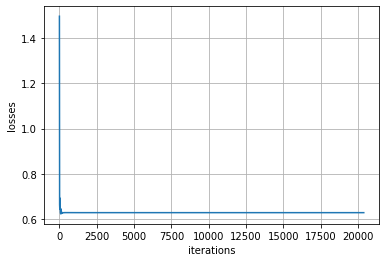

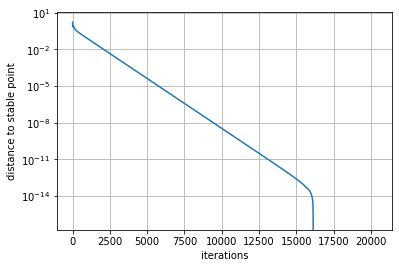

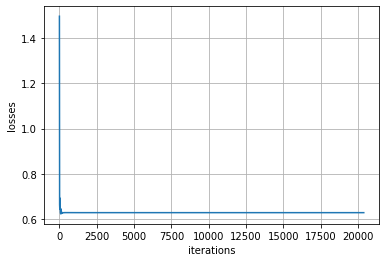

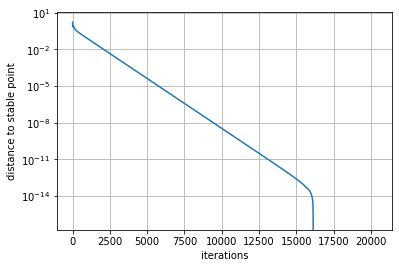

In [45]:
theta_PS, outputs_PS = perf_gd(
    X_ls,
    y_ls,
    theta_init=theta_ERM,
    lam=lam,
    n_deployments=400, #######
    max_iter=50,
    eps_ls=(np.array(eps_ls) * 0.1).tolist(),
    strat_features=strat_features,
    tol=1e-16, #######
)
fig1, fig2 = plot_gd(outputs_PS)
# mlflow.log_figure(fig1, 'loss.png')
# mlflow.log_figure(fig2, 'dtheta.png')
display(fig1)
display(fig2)

  0%|          | 0/200 [00:00<?, ?it/s]

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx...................................Training set loss:  0.6114055023159576


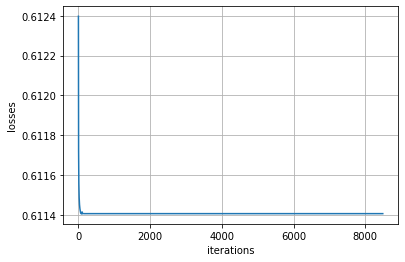

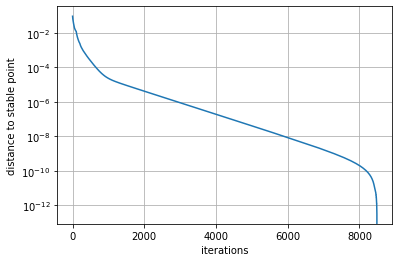

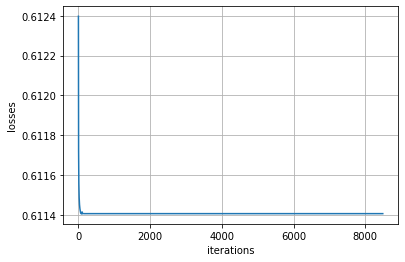

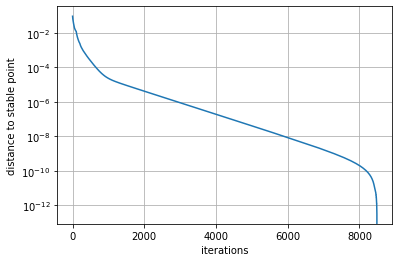

In [13]:
# theta_PS, outputs_PS = perf_gd(
#     X_ls,
#     y_ls,
#     theta_init=theta_ERM,
#     lam=lam,
#     n_deployments=200,
#     max_iter=50,
#     eps_ls=(np.array(eps_ls) * 0.1).tolist(),
#     strat_features=strat_features,
#     tol=1e-12,
# )
# fig1, fig2 = plot_gd(outputs_PS)
# # mlflow.log_figure(fig1, 'loss.png')
# # mlflow.log_figure(fig2, 'dtheta.png')
# display(fig1)
# display(fig2)

In [39]:
strat_features

[2, 4, 6]

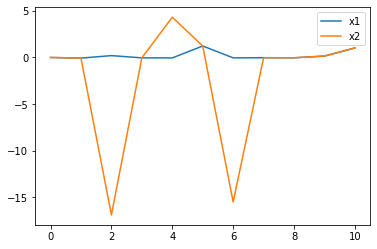

In [46]:
x1 = X[0]
x2 = X[0].copy()
x2[strat_features] -= 10 * theta_ERM[strat_features]
plt.plot(x1, label='x1')
plt.plot(x2, label='x2')
plt.legend()

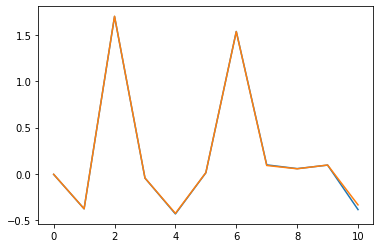

In [30]:
plt.plot(theta_ERM, label='ERM')
plt.plot(theta_PS, label='PS')

## Coef vs lam

In [47]:
thetas = []
losses = []
for lam in [1e-5, 1e-2, 1e-1, 1, 10, 100]:
    # lam = 1e-1 #1 / X.shape[0]

    ### Gradient descent
    # grad_fn = lambda theta: grad(theta, X, Y, lam)
    # loss_fn = lambda theta: loss(theta, X, Y, lam)
    # beta, gamma, cond_num = get_constants(X, lam)
    # stepsize = 1 / beta
    # theta_ERM_lr, outputs_ERM_lr = gd(
    #     theta_init,
    #     grad_fn,
    #     loss_fn,
    #     stepsize,
    #     max_iter=1000,
    #     tol=0,
    # )

    #### Scikit-learn
    reg = LogisticRegression(penalty='l2', fit_intercept=True, C=1/lam/X.shape[0])
    reg.fit(X[:,:-1], Y)
    theta_ERM = np.append(reg.coef_[0], reg.intercept_)

    # Performative prediction
    strat_features = np.array([1, 6, 8]) - 1
    n_clients = 10
    M = X.shape[0] // n_clients
    thetas.append(theta_ERM.copy())

    y = Y
    X = X
    theta = theta_ERM

    n = y.shape[0]
    xth = X @ theta
    l_log = - y.dot(xth) / n + np.mean(np.log(1 + np.exp(xth)))
    l_reg = lam / 2 * np.linalg.norm(theta[:-1])**2
    losses.append([l_log, l_reg])

In [37]:
y = Y
X = X
theta = theta_ERM

n = y.shape[0]
xth = X @ theta
l_log = - y.dot(xth) / n + np.mean(np.log(1 + np.exp(xth)))
l_reg = lam / 2 * np.linalg.norm(theta[:-1])**2

In [38]:
l_log, l_reg

(0.6459639321547377, 0.012439025353628314)

In [50]:
X.std(axis=0)

array([0.53132199, 0.96988203, 1.99003861, 0.85312128, 0.44550033,
       1.03063819, 2.00735702, 1.1023101 , 2.00927171, 1.04456919,
       0.        ])

0.001 [0.6098236120620858, 3.1102813595841504e-05]
0.01 [0.6163861181943976, 0.01138657794503255]
0.1 [0.6459639321547377, 0.012439025353628314]
1 [0.6736301473130892, 0.005771631199415328]
10 [0.6856200371986956, 0.0016023678724886943]


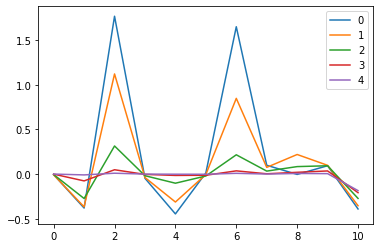

In [48]:
for i, lam in enumerate([1e-3, 1e-2, 1e-1, 1, 10]):
    plt.plot(thetas[i], label=f'{i}')
    print(lam, losses[i])
plt.legend()

## Cross Validation

In [84]:
from sklearn.model_selection import GridSearchCV
lam = 10 / X.shape[0]
reg = LogisticRegression(penalty='l2', fit_intercept=True, C=1/lam/X.shape[0])

In [85]:
grid = {
    'C': np.logspace(-1, 2, 50),
}
search = GridSearchCV(reg, grid)
search.fit(X, Y)
df = pd.DataFrame(search.cv_results_)
# df['C'] = df['params'].apply(lambda x: x['C'])

In [77]:
# now find the best C
best_C = df.loc[df['rank_test_score'] == 1, 'param_C'].values[0]

In [78]:
best_C

0.8286427728546845

In [79]:
1 / X.shape[0] / best_C

6.574018851878459e-05

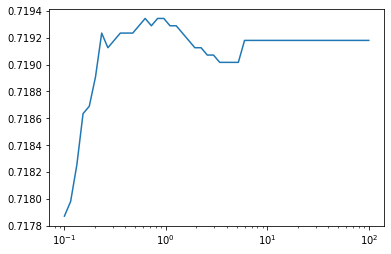

In [87]:
plt.plot(df['param_C'], df['mean_test_score'])
plt.xscale('log')

## Compare gd and sklearn

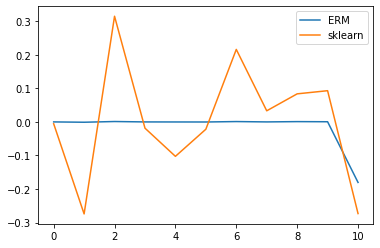

In [65]:
plt.plot(theta_ERM, label='ERM')
plt.plot(theta_ERM_lr, label='sklearn')
plt.legend()

# plot_gd(outputs_ERM, target=theta_ERM_lr)

In [4]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('-K', '--K', type=int, default=10)
parser.add_argument('-E', '--E', type=int, default=5)
parser.add_argument('--eps_max', type=float, default=11)
parser.add_argument('--eps_min', type=float, default=9)
parser.add_argument('-r', '--replace', type=bool, default=False)
parser.add_argument('-s', '--seed', type=int, default=None,
                    help='Seed for SGD, not for eps_ls generation.')
parser.add_argument('-b', '--batch_size', type=int, default=-1)
parser.add_argument('-n', '--n_rounds', type=int, default=int(1e6))
args = parser.parse_args([])


  0%|          | 0/200 [00:00<?, ?it/s]

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxTraining set loss:  0.6099838020511237


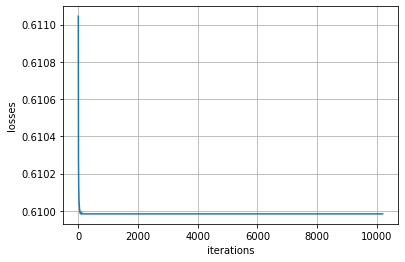

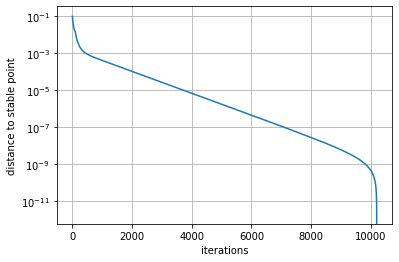

In [5]:

data_type = '5-partition'
batch_size = args.batch_size if args.batch_size > 0 else None
np.random.seed(0)
unif = np.random.rand(n_clients)
eps_range = args.eps_max - args.eps_min
eps_ls = (args.eps_min + unif * eps_range).tolist()
replace = args.replace
full_participation = args.K == n_clients

np.random.seed(args.seed)

# data
if data_type == 'static': # identical static data
    X_ls = [np.copy(X[:M]) for _ in range(n_clients)]
    y_ls = [np.copy(Y[:M]) for _ in range(n_clients)]
elif data_type == '5-partition':
    X_ls, y_ls = [], []
    for k in range(n_clients):
        s = slice(k * M, (k+1) * M)
        X_ls.append(X[s])
        y_ls.append(Y[s])

mlflow.set_experiment('test')
# with mlflow.start_run():
########################### Static begins
#mlflow.set_tag("static", True)
########################### Static ends

# PS solution
theta_PS, outputs_PS = perf_gd(
    X_ls,
    y_ls,
    theta_init=theta_ERM,
    lam=lam,
    n_deployments=200,
    max_iter=50,
    eps_ls=eps_ls,
    strat_features=strat_features,
    tol=1e-12,
)
fig1, fig2 = plot_gd(outputs_PS)
# mlflow.log_figure(fig1, 'loss.png')
# mlflow.log_figure(fig2, 'dtheta.png')



In [6]:
losses, thetas = zip(*outputs_PS)

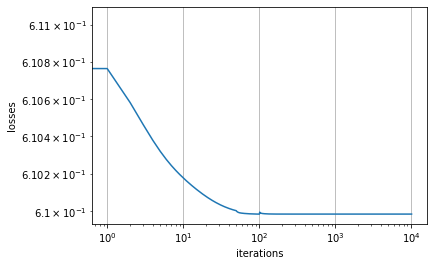

In [7]:
fig = plt.figure()
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('losses')
plt.yscale('log')
plt.xscale('log')
plt.grid()

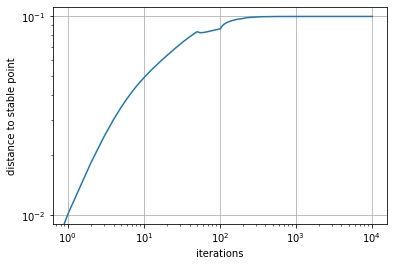

In [8]:
target = theta_ERM
distance_PS = [np.linalg.norm(theta-target) for theta in thetas]

fig = plt.figure()
plt.plot(distance_PS)
plt.xlabel('iterations')
plt.ylabel('distance to stable point')
plt.yscale('log')
plt.xscale('log')
plt.grid()

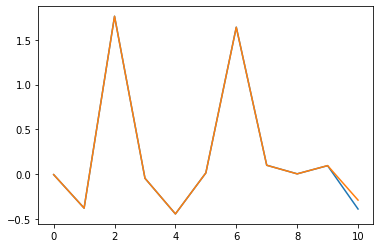

In [6]:
plt.plot(theta_ERM, label='ERM')
plt.plot(theta_PS, label='PS')

In [3]:
import matplotlib.pyplot as plt
plt.plot(theta_ERM - theta_PS)

NameError: name 'theta_ERM' is not defined

In [10]:
np.sum((theta_ERM - theta_PS) ** 2) ** (1/2)

0.09977057681410985

In [1]:
glob = np.array([1, 2, 3])
theta = np.copy(glob)
gradient = np.array([0, 0, 1])
theta -= gradient
local = theta
print(local)
theta = np.copy(glob)
print(local)

[1 2 2]
[1 2 2]


In [48]:

# PS fedavg
# mlflow.log_params({
#     'data': data_type,
#     'lam': lam,
#     'E': args.E,
#     'eps': eps_ls,
#     'N': n_clients,
#     'K': args.K,
#     'batch_size': batch_size,
#     'replace': replace,
#     'seed': args.seed,
#     'n_rounds': args.n_rounds,
# })
theta_PF, outputs_PF = perf_fed_avg(
    X_ls,
    y_ls,
    theta_init=np.copy(theta_ERM), #np.zeros(theta_ERM.shape)
    lam=lam,
    n_rounds=args.n_rounds,
    E=args.E,
    batch_size=batch_size,
    p_ls=None, # inferred from data
    eps_ls=eps_ls,
    strat_features=strat_features,
    full_participation=full_participation,
    K=args.K,
    replace=replace,
    theta_PS=theta_PS,
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 